# Basic goal: Proof of concept

Demonstrate it is possible to apply k-anonymity for very short texts while preserving
functionality. 
A good way to estimate functionality is to have a battery of standard
ML tasks, such as sentiment analysis or topic modeling and test their performance on the text before and after the anonymization for consistency.

1. take very short texts
2. apply k=2 annonymity
3. check functionality:
  3.1 sentiment analysis score
  3.2 topic modeling
4. compare perofomance before and after anonymization


## This POC  stage of the project will be divided into several notebooks:

### 1) Filtering very short texts from our dataset:
        Input: the entire original dataset
        Output = > N original docs (labeled)
### 2) Perfoming BoW K2 Anonymity
        Input: filtered short docs from the original dataset 
        Output = > N anonymity docs (labeled)
### 3) Functionality Tests: Semantic and Topic Modeling
        Input: N docs (labeled)
        Output: Score for each test

In [ ]:
##################################################################################################

## 1) POC, Filtering very short texts from our dataset

In [ ]:
# Imports
import sklearn
import pandas as pd
import numpy as np
import random
import re
from numpy.linalg import norm
from sklearn.model_selection import train_test_split
from itertools import islice
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# Uploading the data
COLAB = True

In [ ]:
if COLAB:
    from google.colab import drive
    from os.path import exists

    amazon_train_file = 'train.ft.txt.bz2'

    if exists(amazon_train_file):
        train_file = amazon_train_file
    else:
        drive.mount('/content/drive/')

        # For Hadas' drive
        #my_dir = 'drive/MyDrive/Y-data/Intuit-K-anonimity/'

        # For Lior's drive
        my_dir = 'drive/MyDrive/Y-data/Y-DATA_PROJECT/'

        train_file = my_dir + '/train.ft.txt.bz2'
else:
    train_file = '../data/' + 'train.ft.txt.bz2'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Credit https://www.kaggle.com/code/anshulrai/cudnnlstm-implementation-93-7-accuracy

import bz2

# Readling the file to list of comments
train_file = bz2.BZ2File(train_file)
train_file_lines = train_file.readlines()

# Converting from raw binary strings to strings that can be parsed
train_file_lines = [x.decode('utf-8') for x in train_file_lines]

# Extracting the labels and sentences
train_labels = [0 if x.split(' ')[0] == '__label__1' else 1 for x in train_file_lines]
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_file_lines] # And converting to lower case

In [ ]:
del(train_file_lines)  # Free RAM

In [ ]:
# create a data frame from train data:
df = pd.DataFrame(list(zip(train_sentences, train_labels)), columns =['txt', 'sentiment'])
df.head()

,txt,sentiment
0,stuning even for the non-gamer: this sound tra...,1
1,the best soundtrack ever to anything.: i'm rea...,1
2,amazing!: this soundtrack is my favorite music...,1
3,excellent soundtrack: i truly like this soundt...,1
4,"remember, pull your jaw off the floor after he...",1


In [ ]:
df['num_of_words'] = df['txt'].apply(lambda x : len(x.split(' ')))

In [ ]:
max_len = 30
df_short_sentences = df[df['num_of_words'] <= max_len] # Filtering using pandas is much faster
print(df_short_sentences.shape)

(446508, 3)


In [ ]:
# Free RAM
del(df)

In [ ]:
def jaccard_index(sentence1, sentence2):
    """ Calc Jaccard index for each pair of sentences """
    words1 = set(sentence1.split())
    words2 = set(sentence2.split())
    intersection = len(words1.intersection(words2))
    union = len(words1.union(words2))
    jaccard = intersection / union
    return jaccard

In [ ]:
indices_list = list(df_short_sentences.index)
len(indices_list)

446508

In [ ]:
indices_list_short_1 = indices_list[1:4000] 

In [ ]:
%%time
# Create a list of sentence texts
sentences = list(df_short_sentences.txt.loc[indices_list_short_1])

# Compute the Jaccard index for all pairs of sentences
jaccard_index_dict = {(indices_list_short_1[i],indices_list_short_1[j]): jaccard_index(sentences[i], sentences[j]) for i in range(len(sentences)) for j in range(i+1, len(sentences))}

# Sort the dictionary by its values in descending order
sorted_dict = dict(sorted(jaccard_index_dict.items(), key=lambda item: item[1], reverse=True))

CPU times: user 1min 47s, sys: 2.6 s, total: 1min 49s
Wall time: 2min 5s


In [ ]:
def plot_jaccard_hist(sorted_dict):
  '''creat a hist of jaccard scores'''
  # extract the values from the dictionary
  dic_values = list(sorted_dict.values())

  # plot a histogram of the values
  plt.hist(dic_values, bins=50, range = (0,0.3))

  # set labels and title
  plt.xlabel('Values')
  plt.ylabel('Counts')
  plt.title('Histogram of Jaccard Indecs')

  # display the plot
  plt.show()

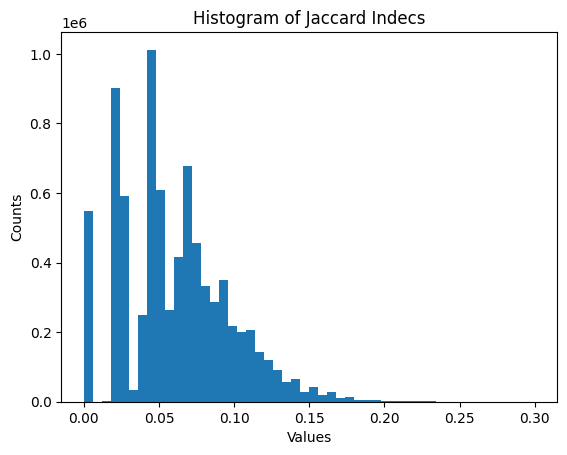

In [ ]:
plot_jaccard_hist(sorted_dict)

In [ ]:
dic_values = list(sorted_dict.values())
print("mean Jaccard:", np.mean(dic_values))

mean Jaccard: 0.12889057084552658


In [ ]:
# Getting the N documents with nearest neighbors
n = 30
first_n_items = dict(islice(sorted_dict.items(), n)) # work with n sentences as a start
# Get the list of indexes
unique_numbers = [num for tup in first_n_items.keys() for num in tup]  # list of indeces for sentences to work with
# Filter the df to recive only these sentences and print df
filtered_df = df_short_sentences.loc[df_short_sentences.index.isin(unique_numbers)]
print(filtered_df.head())

                                                    txt  sentiment  \
269   dockers do the job.: this product was just wha...          1   
370   good deal and fast shipping: i bought this boo...          1   
1112  clean: excellent copy and shipped fast. this i...          1   
1729  outrageously funny: this book is laugh-out-lou...          1   
2861  good movie: i like all of the transformers mov...          1   

      num_of_words  
269             25  
370             27  
1112            21  
1729            24  
2861            26  


# ----------------------#
The output of this stage is: 
## filtered_df
# ----------------------#

## 2) Perfoming BoW K2 Anonymity


using glove to perform word2vec, cluster using dbscan (hdbscan didn't work good guess to the small amount of docs) and switch the words in the text until anonymization

In [ ]:
## Working with a copy of the df:
filtered_df_copy = filtered_df.copy()

In [ ]:
filtered_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44 entries, 269 to 33050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   txt           44 non-null     object
 1   sentiment     44 non-null     int64 
 2   num_of_words  44 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.4+ KB


In [ ]:
import gensim.downloader as api
glove_model = api.load('glove-twitter-25')

In [ ]:
X = filtered_df_copy['txt']
y = filtered_df_copy['sentiment']  # currently not in use

In [ ]:
from keras.preprocessing.text import Tokenizer
vocab_size = 10000
oov_token = "<OOV>"  # words OOV
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X)

In [ ]:
# mapping of the words to numbers
word_index = tokenizer.word_index

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

sw = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# using CHATGPT
# Iterate over your dictionary of words and embed them using GloVe
embedded_dict = {}
for word, idx in word_index.items():
    if word not in sw:
        try:
            embedded_dict[word] = glove_model[word]
        except KeyError:
            # If the word is not in the GloVe vocabulary, assign a default embedding or skip it
            pass

In [ ]:
embeddings = np.array(list(embedded_dict.values()))

In [ ]:
## DBSCAN 
!pip install --upgrade kneed

In [ ]:
## CODE USED TO FINED EPS VALUE == NO NEED TO RUN THIS AGAIN
if True: 
    from kneed import KneeLocator
    from sklearn.neighbors import NearestNeighbors

    # Compute the k-distances for each point
    k = 10
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(embeddings)
    distances, indices = neigh.kneighbors(embeddings)

    # Sort the distances and flatten them into a 1D array
    sorted_distances = np.sort(distances[:,k-1], axis=None)

    # Plot the k-distance graph
    # plt.plot(sorted_distances)

    # Find the elbow point
    kneedle = KneeLocator(range(len(sorted_distances)), sorted_distances, S=1.0, curve='concave', direction='increasing')
    eps = sorted_distances[kneedle.elbow]

    print(f"Estimated eps value: {eps}")
    first_run=False

In [ ]:
dbscan = DBSCAN(eps=eps, min_samples=2)  # <0.5 returned only one cluster. Chose 3 a min words per cluster (maybe reduce to 2?) Maybe according to k

In [ ]:
dbscan.fit(embeddings)


DBSCAN(eps=2.304003908319602, min_samples=2)

In [ ]:
labels = dbscan.labels_
labels

array([ 0,  1,  2,  2, -1,  3,  4,  2,  2, -1,  2,  5,  2,  2,  6,  2, -1,
        2,  2, -1,  0,  2,  7,  2, -1,  4, -1,  2, -1, -1,  8, -1, -1,  2,
       -1,  2,  9, -1, -1,  2, -1, -1, -1, -1,  7, -1, 10, 11,  2, -1, -1,
        2,  3,  2, -1,  2,  2, -1, 12, -1, 10, -1, -1,  2, -1, 13, 13,  2,
        2,  2,  2, -1, -1,  2,  2,  4, -1,  2,  2,  2, -1, -1,  8,  2, -1,
       -1, -1, -1,  4, -1,  4,  2, -1, -1,  2, -1,  2, 10,  2, -1,  2, -1,
       -1,  2, -1,  2, -1, -1,  2,  2,  2,  2,  2, -1,  4, 11, 14, -1, -1,
        5, -1, -1, -1,  2, -1,  2, -1,  2, -1,  2, -1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  2, -1, -1, -1, -1, -1, -1,  2,  2, -1, -1,  2,
        2, -1, -1,  9, -1, -1, -1,  2,  2, -1,  2,  2, -1, -1,  2, -1, -1,
       15, -1, -1, -1, -1, -1, -1, -1,  2, -1,  0, -1, -1, -1,  2,  2, -1,
       -1,  2, -1, -1, -1, -1, 16,  2, -1,  2, -1,  2, -1, -1, -1,  8,  2,
       12,  2, 16, 14, -1, -1, -1, -1, 15, -1,  6, -1, -1, -1, -1, -1, -1,
        2, 10, -1, -1, -1

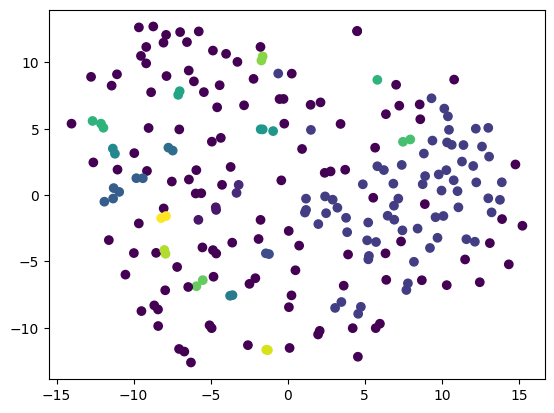

In [ ]:
# Import the necessary libraries
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Extract the embeddings from the embedded_dict and store them in a numpy array
embeddings = np.array(list(embedded_dict.values()))

# Perform t-SNE on the embeddings to reduce their dimensionality to 2
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Get the cluster labels assigned by DBSCAN
labels = dbscan.labels_

# Plot the 2D embeddings with different colors for each cluster
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels)
plt.show()

In [ ]:
clusters = {}
for i, key in enumerate(embedded_dict.keys()):
    cluster = labels[i]
    if cluster not in clusters:
        clusters[cluster] = []
    clusters[cluster].append(key)

In [ ]:
for key, val in clusters.items():
    print(f'Cluster {key} includes {len(val)} words')

Cluster 0 includes 3 words
Cluster 1 includes 2 words
Cluster 2 includes 69 words
Cluster -1 includes 119 words
Cluster 3 includes 2 words
Cluster 4 includes 6 words
Cluster 5 includes 2 words
Cluster 6 includes 2 words
Cluster 7 includes 2 words
Cluster 8 includes 3 words
Cluster 9 includes 2 words
Cluster 10 includes 4 words
Cluster 11 includes 2 words
Cluster 12 includes 2 words
Cluster 13 includes 2 words
Cluster 14 includes 2 words
Cluster 15 includes 2 words
Cluster 16 includes 2 words


In [ ]:
def get_general_word_from_cluster(word_list, we_model):
    """ Finds the most similar words usind word embedding"""
    glove_words = list(we_model.index_to_key)
    known_words = [w for w in word_list if w in glove_words]
    if len(known_words) > 0:
        we_word = we_model.most_similar(known_words, topn=1)[0][0]
    else:
        we_word = None
    return we_word

In [ ]:
filtered_df_copy['anon_txt'] = filtered_df_copy['txt']
filtered_df_copy['anon_txt_clean'] = filtered_df_copy['txt']

# create a list of the "new" words and don't cluster them in the next round
new_words = []
for key, words in clusters.items(): 
    if key >= 0:  # Ignoring the -1 label
      if len(clusters[key])<10: # so it will make sense!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            general_word = get_general_word_from_cluster(words, glove_model)
            new_words.append(general_word)  # the list of new words
            print('\treplacing', words, 'in', general_word)
            for word in words:
                filtered_df_copy['anon_txt'] = filtered_df_copy['anon_txt'].apply(lambda x: x.replace(word, ''.join([word ,'[', general_word,']'])))
                filtered_df_copy['anon_txt_clean'] = filtered_df_copy['anon_txt_clean'].apply(lambda x: x.replace(word, general_word))

	replacing ['book', 'books', 'review'] in script
	replacing ['read', 'reading'] in write
	replacing ['movie', 'movies'] in songs
	replacing ['product', 'business', 'quality', 'service', 'job', 'company'] in management
	replacing ['excellent', 'addition'] in fantastic
	replacing ['dvd', 'cd'] in hd
	replacing ['purchase', 'shipping'] in cards
	replacing ['within', 'upon', 'throughout'] in through
	replacing ['timely', 'prompt'] in in-depth
	replacing ['bought', 'ordered', 'shipped', 'purchased'] in sold
	replacing ['used', 'found'] in called
	replacing ['piece', 'classic'] in black
	replacing ['satisfied', 'happier'] in unhappy
	replacing ['animation', 'fiction'] in illustration
	replacing ['brooklyn', 'west'] in houston
	replacing ['philosophy', 'science'] in psychology


In [ ]:
filtered_df_copy.head()

,txt,sentiment,num_of_words,anon_txt,anon_txt_clean
269,dockers do the job.: this product was just wha...,1,25,dockers do the job[management].: this product[...,dockers do the management.: this management wa...
370,good deal and fast shipping: i bought this boo...,1,27,good deal and fast shipping[cards]: i bought[s...,good deal and fast cards: i sold this script c...
1112,clean: excellent copy and shipped fast. this i...,1,21,clean: excellent[fantastic] copy and shipped[s...,clean: fantastic copy and sold fast. this is o...
1729,outrageously funny: this book is laugh-out-lou...,1,24,outrageously funny: this book[script] is laugh...,outrageously funny: this script is laugh-out-l...
2861,good movie: i like all of the transformers mov...,1,26,good movie[songs]: i like all of the transform...,good songs: i like all of the transformers son...


calc again Jacard and show distr:


In [ ]:
%%time
# Create a list of sentence texts
sentences = list(filtered_df_copy.anon_txt_clean)

# Compute the Jaccard index for all pairs of sentences
jaccard_index_dict = {(indices_list_short_1[i],indices_list_short_1[j]): jaccard_index(sentences[i], sentences[j]) for i in range(len(sentences)) for j in range(i+1, len(sentences))}

# Sort the dictionary by its values in descending order
sorted_dict = dict(sorted(jaccard_index_dict.items(), key=lambda item: item[1], reverse=True))

CPU times: user 17.7 ms, sys: 0 ns, total: 17.7 ms
Wall time: 20.1 ms


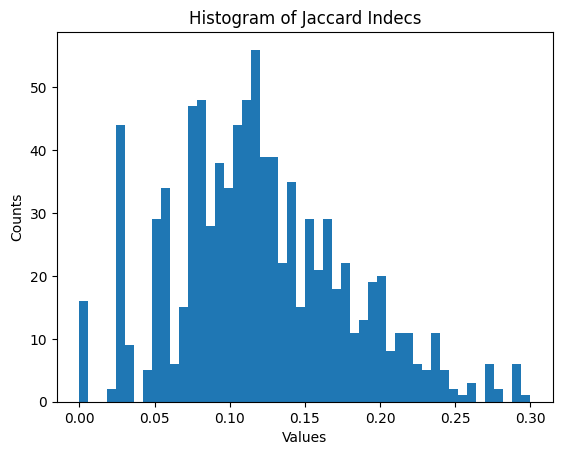

In [ ]:
# plot again jaccard dist

plot_jaccard_hist(sorted_dict)

In [ ]:
print("mean Jaccard:", np.mean(values))

mean Jaccard: 0.12889057084552658


## Perform another cycle of clustering and switching

X = the anon_clean text
ignore "new_words"

In [ ]:
new_words

['script',
 'write',
 'songs',
 'management',
 'fantastic',
 'hd',
 'cards',
 'through',
 'in-depth',
 'sold',
 'called',
 'black',
 'unhappy',
 'illustration',
 'houston',
 'psychology']

In [ ]:
# taking x as the new column:
X = filtered_df_copy['anon_txt_clean']

In [ ]:
# creating word embedding:
tokenizer.fit_on_texts(X)

In [ ]:
# mapping of the words to numbers
word_index = tokenizer.word_index

In [ ]:
# Iterate over your dictionary of words and embed them using GloVe
embedded_dict = {}
for word, idx in word_index.items():
    if word not in sw:
        try:
            embedded_dict[word] = glove_model[word]
        except KeyError:
            # If the word is not in the GloVe vocabulary, assign a default embedding or skip it
            pass

In [ ]:
# try add not int new_words
embedded_dict = {}
for word, idx in word_index.items():
    if word not in sw:
      if word not in new_words:
          try:
              embedded_dict[word] = glove_model[word]
          except KeyError:
              # If the word is not in the GloVe vocabulary, assign a default embedding or skip it
              pass

In [ ]:
embeddings = np.array(list(embedded_dict.values()))

In [ ]:
## CODE USED TO FINED EPS VALUE == NO NEED TO RUN THIS AGAIN
if True: 
    from kneed import KneeLocator
    from sklearn.neighbors import NearestNeighbors

    # Compute the k-distances for each point
    k = 10
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(embeddings)
    distances, indices = neigh.kneighbors(embeddings)

    # Sort the distances and flatten them into a 1D array
    sorted_distances = np.sort(distances[:,k-1], axis=None)

    # Plot the k-distance graph
    #plt.plot(sorted_distances)

    # Find the elbow point
    kneedle = KneeLocator(range(len(sorted_distances)), sorted_distances, S=1.0, curve='concave', direction='increasing')
    eps = sorted_distances[kneedle.elbow]

    print(f"Estimated eps value: {eps}")

    first_run=False

Estimated eps value: 2.321795776165661


In [ ]:
dbscan = DBSCAN(eps=eps, min_samples=2)  # <0.5 returned only one cluster. Chose 3 a min words per cluster (maybe reduce to 2?) Maybe according to k

In [ ]:
dbscan.fit(embeddings)


DBSCAN(eps=2.321795776165661, min_samples=2)

In [ ]:
labels = dbscan.labels_
labels

array([ 0,  1,  0, -1,  0,  0, -1,  0,  2,  0,  0,  3,  0,  4, -1,  0,  0,
       -1,  5,  0,  0, -1, -1,  0, -1, -1, -1,  6, -1,  0, -1,  0, -1, -1,
        0, -1, -1, -1,  0, -1,  0, -1,  1, -1,  0,  0, -1,  0,  0,  7, -1,
       -1, -1, -1,  0,  4, -1,  0,  0,  0,  0, -1, -1,  0,  0, -1,  0,  0,
        0, -1, -1,  0, -1, -1, -1, -1, -1, -1,  8,  9, -1,  0, -1,  7, -1,
       10, 11,  0, -1,  0,  0, -1,  0, -1, -1,  0, -1,  0, -1, -1,  3,  0,
        0,  0,  0,  0, -1, -1, -1, -1, -1, -1,  0, -1,  0, 12, -1,  0, -1,
        0, 10, -1, -1, -1, -1, -1, -1, -1,  9, -1, -1,  0, -1, -1, -1, -1,
       -1, -1,  0,  0, -1, 13, -1,  0,  0, -1, -1, -1, -1, 13, -1,  0,  0,
       -1,  0,  0, -1, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1,
       -1, -1, -1,  0,  0, -1,  4,  8, -1,  0, -1, -1, -1, -1,  0, -1,  0,
       -1,  0, -1, -1,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        0, -1, -1, -1,  0, -1,  4, -1,  4, 10,  4, 11, 14,  5,  2,  9, 15,
        1, 16, -1,  8, 12

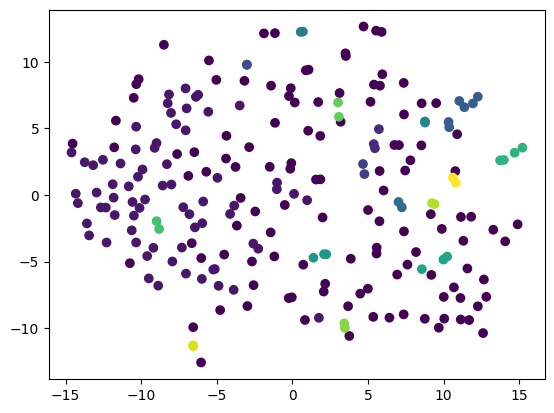

In [ ]:
# plot in 2d
# Extract the embeddings from the embedded_dict and store them in a numpy array
embeddings = np.array(list(embedded_dict.values()))

# Perform t-SNE on the embeddings to reduce their dimensionality to 2
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Get the cluster labels assigned by DBSCAN
labels = dbscan.labels_

# Plot the 2D embeddings with different colors for each cluster
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels)
plt.show()

In [ ]:
clusters = {}
for i, key in enumerate(embedded_dict.keys()):
    cluster = labels[i]
    if cluster not in clusters:
        clusters[cluster] = []
    clusters[cluster].append(key)

In [ ]:
for key, val in clusters.items():
    print(f'Cluster {key} includes {len(val)} words')

Cluster 0 includes 70 words
Cluster 1 includes 3 words
Cluster -1 includes 120 words
Cluster 2 includes 2 words
Cluster 3 includes 2 words
Cluster 4 includes 6 words
Cluster 5 includes 2 words
Cluster 6 includes 2 words
Cluster 7 includes 2 words
Cluster 8 includes 3 words
Cluster 9 includes 3 words
Cluster 10 includes 4 words
Cluster 11 includes 2 words
Cluster 12 includes 2 words
Cluster 13 includes 2 words
Cluster 14 includes 2 words
Cluster 15 includes 2 words
Cluster 16 includes 2 words


In [ ]:
#filtered_df_copy['anon_txt'] = filtered_df_copy['txt']
#filtered_df_copy['anon_txt_clean'] = filtered_df_copy['txt']
new_words_vec = new_words  # rename to clear object
new_words = []  # init new list
for key, words in clusters.items(): 
    if key >= 0:  # Ignoring the -1 label
      if len(clusters[key])<10: # so it will make sense!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!  TRY LESS THAN 10?!?!?!
            general_word = get_general_word_from_cluster(words, glove_model)
            for word in words:
              if word not in new_words_vec:
                new_words.append(general_word)  # the list of new words

                filtered_df_copy['anon_txt'] = filtered_df_copy['anon_txt'].apply(lambda x: x.replace(word, ''.join([word ,'[', general_word,']'])))
                filtered_df_copy['anon_txt_clean'] = filtered_df_copy['anon_txt_clean'].apply(lambda x: x.replace(word, general_word))
                print('\treplacing', word, 'in', general_word)
# drop duplicates:
new_words = list(set(new_words))

	replacing book in script
	replacing books in script
	replacing review in script
	replacing read in write
	replacing reading in write
	replacing movie in songs
	replacing movies in songs
	replacing product in management
	replacing business in management
	replacing quality in management
	replacing service in management
	replacing job in management
	replacing company in management
	replacing excellent in fantastic
	replacing addition in fantastic
	replacing dvd in hd
	replacing cd in hd
	replacing purchase in cards
	replacing shipping in cards
	replacing within in through
	replacing upon in through
	replacing throughout in through
	replacing timely in in-depth
	replacing intriguing in in-depth
	replacing prompt in in-depth
	replacing bought in sold
	replacing ordered in sold
	replacing shipped in sold
	replacing purchased in sold
	replacing used in called
	replacing found in called
	replacing piece in black
	replacing classic in black
	replacing satisfied in unhappy
	replacing happier in

In [ ]:
new_words


['houston',
 'psychology',
 'fantastic',
 'unhappy',
 'black',
 'songs',
 'write',
 'in-depth',
 'cards',
 'called',
 'illustration',
 'sold',
 'through',
 'script',
 'management',
 'hd']

In [ ]:
filtered_df_copy.head(20)

,txt,sentiment,num_of_words,anon_txt,anon_txt_clean
269,dockers do the job.: this product was just wha...,1,25,dockers do the job[management][management].: t...,dockers do the management.: this management wa...
370,good deal and fast shipping: i bought this boo...,1,27,good deal and fast shipping[cards][cards]: i b...,good deal and fast cards: i sold this script c...
1112,clean: excellent copy and shipped fast. this i...,1,21,clean: excellent[fantastic][fantastic] copy an...,clean: fantastic copy and sold fast. this is o...
1729,outrageously funny: this book is laugh-out-lou...,1,24,outrageously funny: this book[script][script] ...,outrageously funny: this script is laugh-out-l...
2861,good movie: i like all of the transformers mov...,1,26,good movie[songs][songs]: i like all of the tr...,good songs: i like all of the transformers son...
2895,cool movie: i had never watched this movie and...,1,30,cool movie[songs][songs]: i had never watched ...,cool songs: i had never watched this songs and...
2949,good purchase!: i love this purchase and i wou...,1,23,good purchase[cards][cards]!: i love this purc...,good cards!: i love this cards and i would rec...
2951,awesome movie: this is a great addition to any...,1,24,awesome movie[songs][songs]: this is a great a...,awesome songs: this is a great fantastic to an...
6900,i think this book is horrible: i have never re...,0,30,i think this book[script][script] is horrible:...,i think this script is horrible: i have never ...
7275,good value: this was ordered for a teenager wh...,1,28,good value: this was ordered[sold][sold] for a...,good value: this was sold for a teenager who h...


In [1]:
filtered_df_copy.info()

NameError: ignored

In [ ]:
%%time
# Create a list of sentence texts
sentences = list(filtered_df_copy.anon_txt_clean)

# Compute the Jaccard index for all pairs of sentences
jaccard_index_dict = {(indices_list_short_1[i],indices_list_short_1[j]): jaccard_index(sentences[i], sentences[j]) for i in range(len(sentences)) for j in range(i+1, len(sentences))}

# Sort the dictionary by its values in descending order
sorted_dict = dict(sorted(jaccard_index_dict.items(), key=lambda item: item[1], reverse=True))

CPU times: user 16.4 ms, sys: 0 ns, total: 16.4 ms
Wall time: 18.4 ms


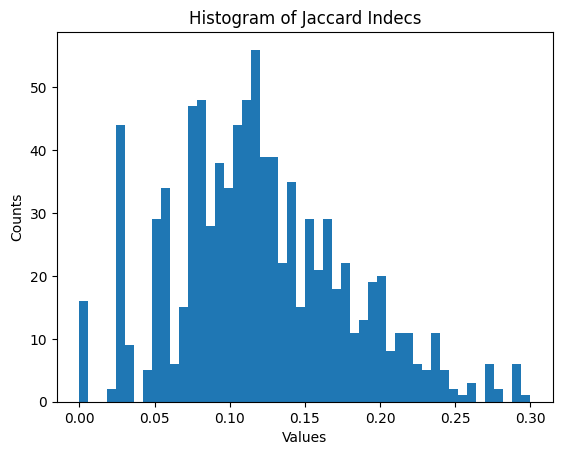

In [ ]:
plot_jaccard_hist(sorted_dict)

In [ ]:
dic_values = list(sorted_dict.values())
print("mean Jaccard:", np.mean(dic_values))

mean Jaccard: 0.12889057084552658


## 3. check functionality:


In [ ]:
# peform test on the data before and after anonymization

In [ ]:
#
ariginal_text = filtered_df_copy.txt
anon_text = filtered_df_copy.anon_txt_clean
labels = filtered_df_copy.sentiment

In [ ]:
# divid to train and test;
train_sentences = ariginal_text[0:1000]
train_labels = labels[0:1000]
test_sentences = ariginal_text[1001:2000]
test_labels = labels[1001:2000]

In [ ]:
# preprocess????

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')  # added


In [ ]:
### https://www.kaggle.com/code/rohitgadhwar/sentiment-analysis-on-amazon-reviews/notebook
def clean_texts(texts):
    stwords = stopwords.words('english')
    l = len(texts)/10
    temp_texts = []
    for i in range(len(texts)):
        text = re.sub('\d','0',texts[i])
        if 'www.' in text or 'http:' in text or 'https:' in text or '.com' in text: # remove links and urls
            text = re.sub(r"([^ ]+(?<=\.[a-z]{3}))", " ", text)
        
        text = re.sub('[^a-zA-Z]', ' ', text)
        text = text.lower()
        text = text.split()
        text = [word for word in text if not word in stwords] # remove stopwords 
        text = ' '.join(text)
        temp_texts.append(text)
        if i%l==0:
            print('--'+str(int(i/l)*10)+'%', end='')
    print('--100%--Done !')
    return temp_texts

In [ ]:
stwords = stopwords.words('english')


In [ ]:
# clean both train and test data:
print('Processing Training data')
train_texts = clean_texts(train_sentences1)
print('\nProcessing Test data')
test_texts = clean_texts(test_sentences)

In [ ]:
sns.countplot(x=train_labels)  # almost even, is it ok?

In [ ]:
# converting a collection of text documents to a matrix of token counts. It essentially converts
# a collection of text documents into a sparse matrix, 
# where each row corresponds to a document and each column corresponds to a token in the corpus.


from sklearn.feature_extraction.text import CountVectorizer

print('Fitting data...')
count_vect = CountVectorizer()
count_vect.fit(train_texts) ; print('fit complete !')

print('tranforming training set...')
train_texts_vec = count_vect.transform(train_texts)

print('tranforming test set...')
test_texts_vec = count_vect.transform(test_texts)

In [ ]:
# train a model

In [ ]:
## Train a model

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(train_texts_vec, train_labels)

MultinomialNB()

In [ ]:
y_pred = nb.predict(test_texts_vec)

In [ ]:
from sklearn.metrics import accuracy_score
print('Accuracy:', accuracy_score(test_labels, y_pred))

Accuracy: 0.847803131869715


In [ ]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(n_jobs=-1, max_iter=150)
lr_model.fit(train_texts_vec, train_labels)

LogisticRegression(max_iter=150, n_jobs=-1)

In [ ]:
pred_lr = lr_model.predict(test_texts_vec)

In [ ]:
print('Accuracy:', accuracy_score(test_labels, pred_lr))

Accuracy: 0.8999286439468541
